In [1]:
#importing the necessary libraries first
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,GlobalAveragePooling2D
from tensorflow.keras.layers import Activation , Dropout, BatchNormalization,Flatten,Dense
from tensorflow.keras.models import Sequential ,Model
from tensorflow.keras.optimizers import Adam
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

2021-09-25 00:07:08.570755: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
data='../input/breast-histopathology-images/8864'
Benign='../input/breast-histopathology-images/8864/0'
Malignant='../input/breast-histopathology-images/8864/1'

In [3]:
dirlist=[Benign,Malignant]
classes=['0','1']
filepaths=[]
labels=[]
for i,j in zip(dirlist,classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join(i,f)
        filepaths.append(filepath)
        labels.append(j)
        print('filepaths:', len(filepaths), 'labels:', len(labels))

filepaths: 1 labels: 1
filepaths: 2 labels: 2
filepaths: 3 labels: 3
filepaths: 4 labels: 4
filepaths: 5 labels: 5
filepaths: 6 labels: 6
filepaths: 7 labels: 7
filepaths: 8 labels: 8
filepaths: 9 labels: 9
filepaths: 10 labels: 10
filepaths: 11 labels: 11
filepaths: 12 labels: 12
filepaths: 13 labels: 13
filepaths: 14 labels: 14
filepaths: 15 labels: 15
filepaths: 16 labels: 16
filepaths: 17 labels: 17
filepaths: 18 labels: 18
filepaths: 19 labels: 19
filepaths: 20 labels: 20
filepaths: 21 labels: 21
filepaths: 22 labels: 22
filepaths: 23 labels: 23
filepaths: 24 labels: 24
filepaths: 25 labels: 25
filepaths: 26 labels: 26
filepaths: 27 labels: 27
filepaths: 28 labels: 28
filepaths: 29 labels: 29
filepaths: 30 labels: 30
filepaths: 31 labels: 31
filepaths: 32 labels: 32
filepaths: 33 labels: 33
filepaths: 34 labels: 34
filepaths: 35 labels: 35
filepaths: 36 labels: 36
filepaths: 37 labels: 37
filepaths: 38 labels: 38
filepaths: 39 labels: 39
filepaths: 40 labels: 40
filepaths: 41 labe

In [4]:
Files=pd.Series(filepaths,name='filepaths')
Label=pd.Series(labels,name='labels')
df=pd.concat([Files,Label],axis=1)
df=pd.DataFrame(np.array(df).reshape(1133,2),columns=['filepaths','labels'])
df.head()

,filepaths,labels
0,../input/breast-histopathology-images/8864/0/8...,0
1,../input/breast-histopathology-images/8864/0/8...,0
2,../input/breast-histopathology-images/8864/0/8...,0
3,../input/breast-histopathology-images/8864/0/8...,0
4,../input/breast-histopathology-images/8864/0/8...,0


In [5]:
print(df['labels'].value_counts())

0    805
1    328
Name: labels, dtype: int64


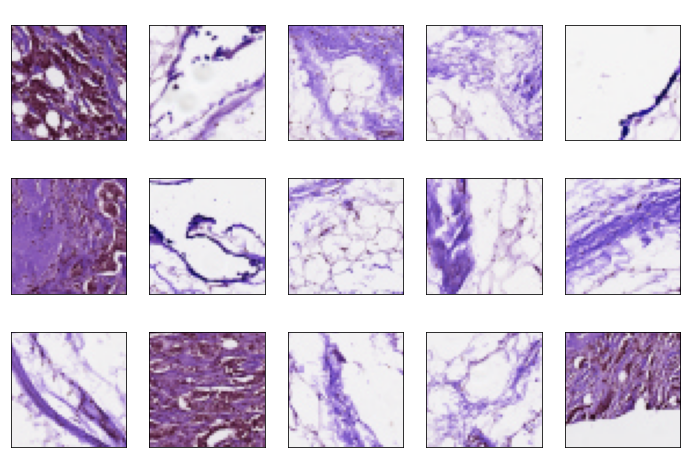

In [6]:
#Visualising the breast tumor images
plt.figure(figsize=(12,8))
for i in range(15):
    random=np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random,"labels"],size=15, color="white")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,train_size=0.95,random_state=0)
train_new,valid=train_test_split(train,train_size=0.90,random_state=0)

print(f"train set shape:{train_new.shape}")
print(f"test set shape:{test.shape}")
print(f"validation set shape:{valid.shape}")

train set shape:(968, 2)
test set shape:(57, 2)
validation set shape:(108, 2)


In [8]:
train_datagen=ImageDataGenerator(rescale=1./255.,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,
                                 shear_range=0.2,zoom_range=0.2,horizontal_flip=True,vertical_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [9]:
train_gen=train_datagen.flow_from_dataframe(dataframe=train_new,
                                           x_col='filepaths',y_col='labels',
                                           target_size=(224,224),batch_size=32,
                                           class_mode='binary',shuffle=True)
val_gen=train_datagen.flow_from_dataframe(valid,target_size=(224,224),x_col='filepaths',y_col='labels',
                                         class_mode='binary',batch_size=16,shuffle=True)
test_gen=test_datagen.flow_from_dataframe(test,target_size=(224,224),x_col='filepaths',y_col='labels',
                                         class_mode='binary',batch_size=16,shuffle=False)

Found 968 validated image filenames belonging to 2 classes.
Found 108 validated image filenames belonging to 2 classes.
Found 57 validated image filenames belonging to 2 classes.


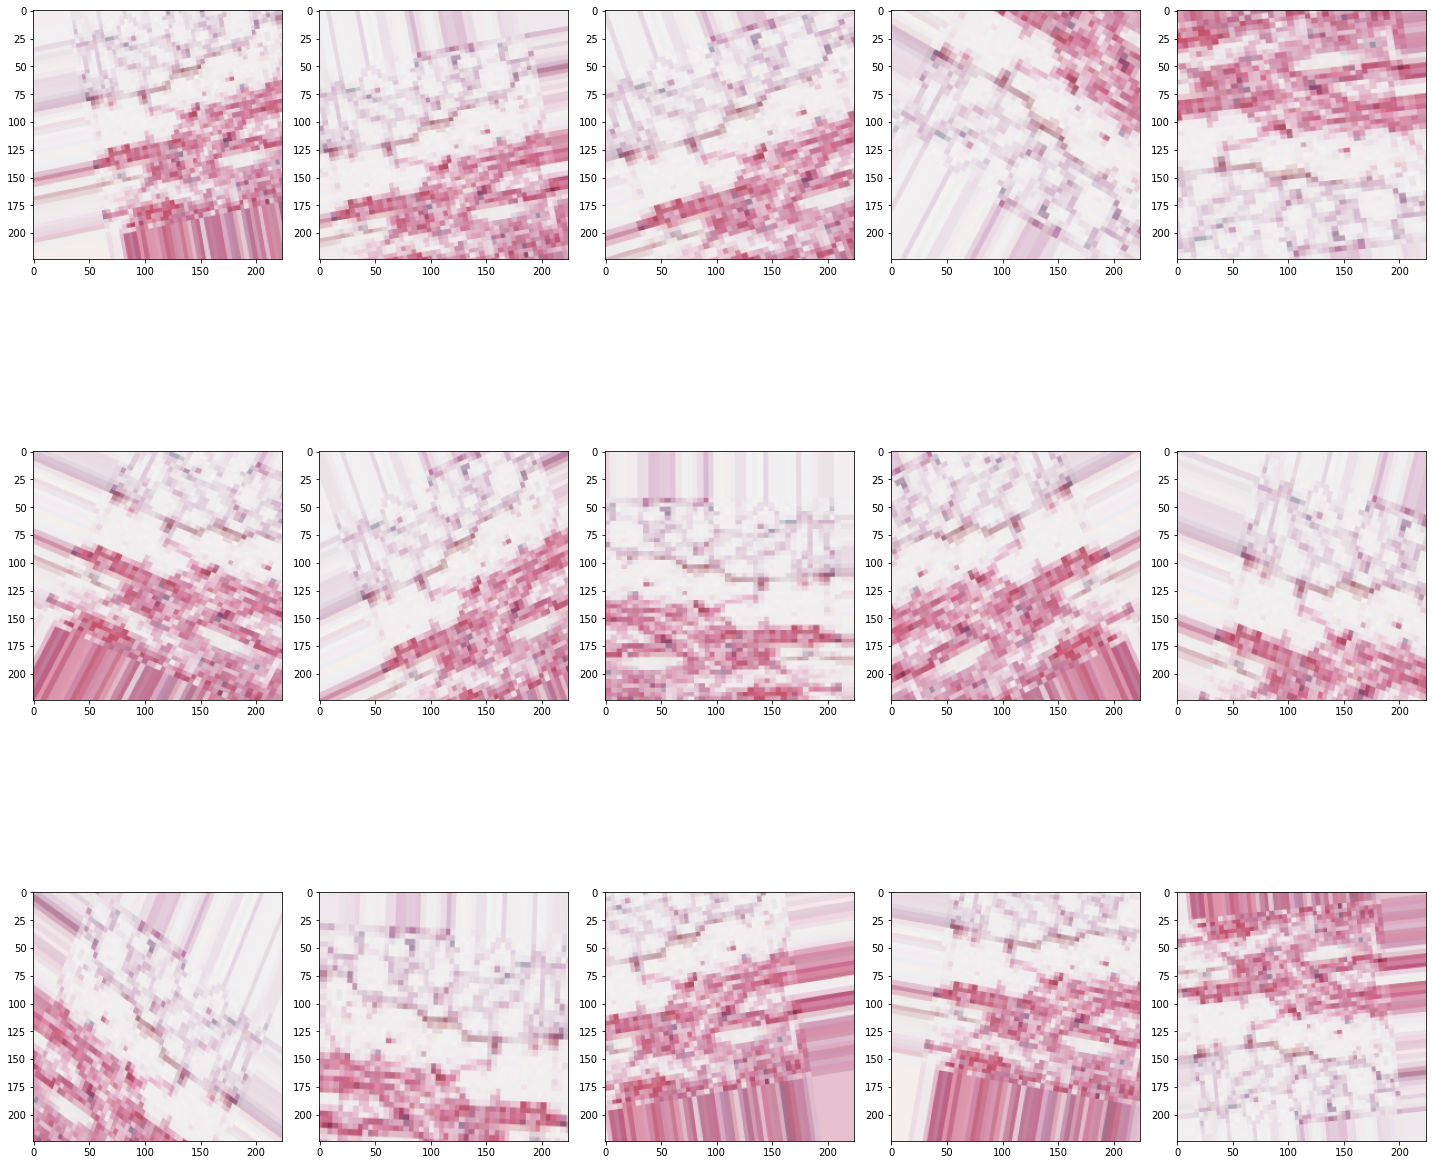

In [10]:
#visualising augumented images using from dataframe
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('on')
    plt.tight_layout()
    plt.show()

augmented_images = [train_gen[0][0][0] for i in range(15)]
plotImages(augmented_images)

In [11]:
file = '../input/breast-histopathology-images/8864/0/8864_idx5_x1001_y1501_class0.png'
table_image_contour = cv2.imread(file, 0)
table_image = cv2.imread(file)

In [12]:
#We shall employ a technique called 
#Inverse Image Thresholding which enhances the data present in the given image.
ret, thresh_value = cv2.threshold(
    table_image_contour, 180, 255, cv2.THRESH_BINARY_INV)

In [13]:
# important preprocessing step is image dilation. Dilation is a simple math operation 
#applied to binary images (Black and White) which gradually enlarges the boundaries of 
#regions of foreground pixels (i.e. white pixels, typically).
kernel = np.ones((5,5),np.uint8)
dilated_value = cv2.dilate(thresh_value,kernel,iterations = 1)


In [14]:
#In OpenCV, we use the method, findContours to obtain the contours in the present image. 
#This method takes three arguments, first is the dilated image (the image that is used to 
#generate the dilated image is table_image_contour - findContours method only supports binary images),
#the second is the cv2.RETR_TREE which tells us to use the contour retrieval mode, the third is the 
#cv2.CHAIN_APPROX_SIMPLE which is the contour approximation mode. The findContours unpacks two values,
#hence we'll add one more variable named hierarchy. When the images are nested, contours exude 
#interdependence. To represent such relationships, hierarchy is used.

contours, hierarchy = cv2.findContours(
    dilated_value, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


In [15]:
#The contours mark where exactly the data is present in the image. Now, we iterate over the
#contours list that we computed in the previous step and calculate the coordinates of the rectangular
#boxes as observed in the original image using the method,  cv2.boundingRect. In the last iteration,
#we put those boxes onto the original image table_image using the method, cv2.rectangle().

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    # bounding the images
    if y < 50:
        table_image = cv2.rectangle(table_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

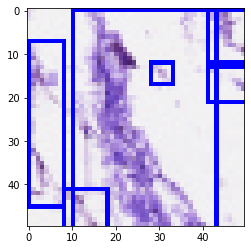

In [16]:
#This is our last step. Here we use the method namedWindow to render our table with the extracted 
#content and contours embedded on it. Below is the code snippet:

plt.imshow(table_image)
plt.show()

In [17]:
table_image

array([[[224, 215, 228],
        [233, 230, 238],
        [241, 241, 242],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[221, 210, 230],
        [239, 236, 242],
        [242, 242, 242],
        ...,
        [241, 240, 244],
        [242, 237, 241],
        [235, 235, 242]],

       [[228, 223, 236],
        [240, 233, 240],
        [240, 242, 242],
        ...,
        [231, 218, 236],
        [221, 211, 229],
        [237, 231, 242]],

       ...,

       [[241, 238, 242],
        [241, 239, 241],
        [241, 239, 242],
        ...,
        [243, 242, 241],
        [241, 241, 242],
        [241, 240, 242]],

       [[241, 240, 242],
        [242, 242, 241],
        [240, 242, 240],
        ...,
        [238, 236, 240],
        [241, 240, 243],
        [241, 240, 242]],

       [[241, 240, 242],
        [240, 240, 240],
        [240, 239, 240],
        ...,
        [235, 229, 242],
        [243, 240, 243],
        [242, 240, 243]]

In [18]:
train_gen.class_indices

{'0': 0, '1': 1}

In [19]:
from tensorflow import keras
base_model=keras.applications.VGG16(weights="imagenet", #load weights pretrained on imagenet
                        input_shape=(224,224,3),include_top=False)#Do not include the imagenet classifier at thetop


#freeze the base model
base_model.trainable=False

#create a new model on top

inputs=keras.Input(shape=(224,224,3))

#The basemodel contains batchnorm layers, I want to keep them in inference mode
#when I unfreeze the basemodel for fine_tuning , so I'll have to make sure that
# the basemodel is running in inference mode here

x=base_model(inputs,training=False)
x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dropout(0.2)(x) #Regularize with dropout
outputs=keras.layers.Dense(1,activation="sigmoid")(x)
model=keras.Model(inputs,outputs)

model.summary()

2021-09-25 00:07:24.237890: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-25 00:07:24.240856: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-25 00:07:24.279376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 00:07:24.279981: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-25 00:07:24.280036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-25 00:07:24.304755: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
callbacks=[
    tf.keras.callbacks.ModelCheckpoint("IDC_model.h5",save_best_only=True,verbose=0)
]

In [21]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

In [22]:
history=model.fit(train_gen,validation_data=val_gen,epochs=100,callbacks=[callbacks],verbose=1)

2021-09-25 00:07:27.899711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-25 00:07:27.903745: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/100


2021-09-25 00:07:28.827327: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-25 00:07:29.699070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-25 00:07:29.732574: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


31/31 [==============================] - 29s 629ms/step - loss: 0.6870 - accuracy: 0.5587 - val_loss: 0.6500 - val_accuracy: 0.7222
Epoch 2/100
31/31 [==============================] - 13s 405ms/step - loss: 0.6593 - accuracy: 0.6403 - val_loss: 0.6253 - val_accuracy: 0.7315
Epoch 3/100
31/31 [==============================] - 12s 385ms/step - loss: 0.6289 - accuracy: 0.7111 - val_loss: 0.6178 - val_accuracy: 0.7315
Epoch 4/100
31/31 [==============================] - 12s 395ms/step - loss: 0.6205 - accuracy: 0.7027 - val_loss: 0.6052 - val_accuracy: 0.7315
Epoch 5/100
31/31 [==============================] - 12s 387ms/step - loss: 0.5990 - accuracy: 0.7315 - val_loss: 0.5954 - val_accuracy: 0.7315
Epoch 6/100
31/31 [==============================] - 12s 388ms/step - loss: 0.5823 - accuracy: 0.7484 - val_loss: 0.5816 - val_accuracy: 0.7315
Epoch 7/100
31/31 [==============================] - 13s 412ms/step - loss: 0.5846 - accuracy: 0.7291 - val_loss: 0.5756 - val_accuracy: 0.7315
Epoc

In [23]:
model.save("IDC.h5")

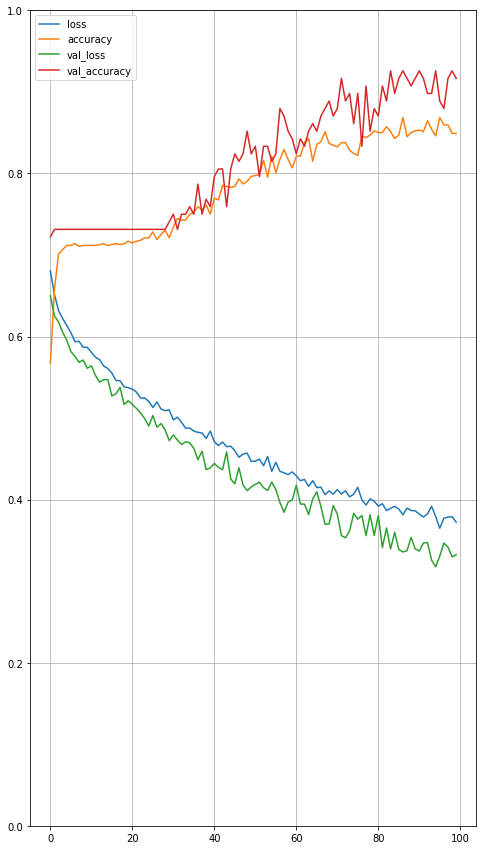

In [24]:
#Evaluating the Model
pd.DataFrame(history.history).plot(figsize=(8,15))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [25]:
from PIL import Image
model_path="./IDC.h5"
loaded_model=tf.keras.models.load_model(model_path)

In [26]:
import numpy as np
#Preprocessing of the image
image=cv2.imread("../input/breast-histopathology-images/10254/0/10254_idx5_x1001_y1001_class0.png")

image_fromarray=Image.fromarray(image,'RGB')
resize_image=image_fromarray.resize((224,224))
expand_input=np.expand_dims(resize_image, axis=0)
input_data=np.array(expand_input)
input_data=input_data/255

In [27]:
#Printing input_data shape
print(input_data.shape)

(1, 224, 224, 3)


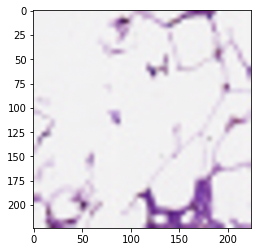

Benign


In [28]:
# Print image
import matplotlib.pyplot as plt
plt.imshow(input_data[0])
plt.show()

pred=loaded_model.predict(input_data)
if pred>=0.5:
    print("Malignant")
else:
    print("Benign")

In [29]:
val_loss,val_accuracy=model.evaluate(val_gen,verbose=2)
print('\nValidation accuracy:',val_accuracy,'\nValidation loss:',val_loss)

7/7 - 1s - loss: 0.3388 - accuracy: 0.8889

Validation accuracy: 0.8888888955116272 
Validation loss: 0.33878093957901


In [30]:
loss,accuracy=model.evaluate(train_gen,verbose=2)
print('\nTraining accuracy:',accuracy,'\nTraining loss:',loss)

31/31 - 11s - loss: 0.3722 - accuracy: 0.8698

Training accuracy: 0.8698347210884094 
Training loss: 0.37216848134994507
